## Time Series Forecasting
Models to test: 
1. Simple moving average method
2. Exponential Smoothing: Simple Exponential Smoothing technique, Holt’s method with trend and Holt Winter’s method
3. Auto Regressive methods: ARIMA/SARIMA

- numpy==1.21.6
- scipy==1.7.3
- pandas==1.1.5
- matplotlib==3.4.3
- pmdarima==2.0.4

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
from scipy.stats import variation


from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
import sklearn
from sklearn.metrics import mean_squared_error,mean_absolute_error

%matplotlib  inline
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")



In [80]:
df = pd.read_csv('/Users/eleanatanrui/Documents/data-science/forecasting/time_series/datasets/coffee_sales.csv')

print(f"{df.shape[0]} Rows & {df.shape[1]} Columns")
print("------")
print(df.dtypes)
df.head(5)

1395 Rows & 6 Columns
------
date            object
datetime        object
cash_type       object
card            object
money          float64
coffee_name     object
dtype: object


,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


### Creating the time series data and train-test data

In [81]:
df['date'] = pd.to_datetime(df['date'])
df_daily = df.groupby('date')['money'].sum().reset_index()
df_daily.head(5)

,date,money
0,2024-03-01,396.3
1,2024-03-02,228.1
2,2024-03-03,349.1
3,2024-03-04,135.2
4,2024-03-05,338.5


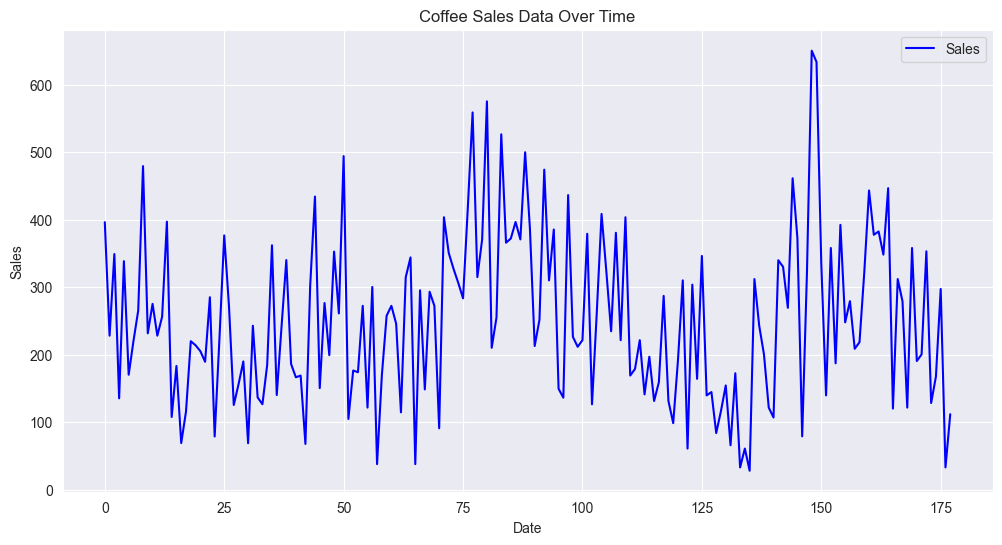

In [82]:
plt.figure(figsize=(12, 6)) 
plt.plot(df_daily.index, df_daily['money'], label='Sales', color='blue')  
plt.title('Coffee Sales Data Over Time')  
plt.xlabel('Date')  
plt.ylabel('Sales')  
plt.legend()  
plt.grid(True)  
plt.show()  

In [83]:
train_size = int(len(df_daily) * 0.8)
train, test = df_daily[:train_size], df_daily[train_size:]

### Forecasting on Test set

In [84]:
# Simple Moving Average Method
def moving_average_forecast(train, test, n=5):
    test['moving_average_forecast'] = train['money'].rolling(window=n).mean().iloc[-1]
    return test['moving_average_forecast']

# Simple Exponential Smoothing
def ses_forecast(train, test, smoothing_level=0.2,optimized=False):
    ses_model = SimpleExpSmoothing(train['money']).fit(smoothing_level=smoothing_level, optimized=False)
    test['SES_forecast'] = ses_model.forecast(len(test))
    return test['SES_forecast']

# Holt’s Linear Trend Model
def holt_forecast(train, test):
    holt_model = ExponentialSmoothing(train['money'], trend='add').fit()
    test['Holt_forecast'] = holt_model.forecast(len(test))
    return test['Holt_forecast']

# Holt-Winters Method (Seasonal)
def holt_winters_forecast(train, test, seasonal_periods=7):
    hw_model = ExponentialSmoothing(train['money'], trend='add', seasonal='add', seasonal_periods=seasonal_periods).fit()
    test['Holt_Winters_forecast'] = hw_model.forecast(len(test))
    return test['Holt_Winters_forecast']


### Auto Regressive Methods

#### >> Stationary Test

In [85]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def results_adfuller_test(pvalue, sig_level):
    if pvalue < sig_level: 
        return print(">> REJECT H_0: Time series is stationary, proceed without differencing")
    return print(">> Cannot reject H_0: Time series is not stationary, differencing is required")

result = adfuller(df['money'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 
results_adfuller_test(result[1],0.05)

ADF Statistic: -2.3778383721736285
p-value: 0.14808930098685436
Critial Values:
   1%, -3.4351321860409674
Critial Values:
   5%, -2.863651979448174
Critial Values:
   10%, -2.567894416324791
>> Cannot reject H_0: Time series is not stationary, differencing is required


#### >> Differencing

In [86]:
df_diff = df['money'].diff().dropna()
result = adfuller(df_diff, autolag='AIC')

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 
results_adfuller_test(result[1],0.05)

ADF Statistic: -13.425014548988011
p-value: 4.1183762284596753e-25
Critial Values:
   1%, -3.435135685820292
Critial Values:
   5%, -2.863653523836867
Critial Values:
   10%, -2.5678952387601703
>> REJECT H_0: Time series is stationary, proceed without differencing


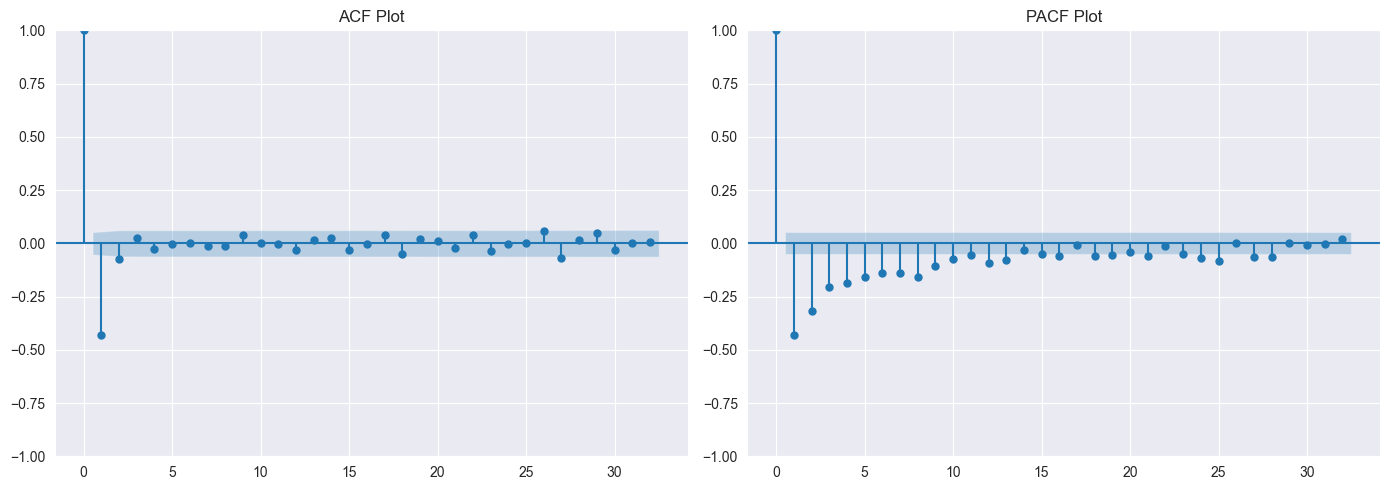

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(df_diff, ax=axes[0])
plot_pacf(df_diff, ax=axes[1])

axes[0].set_title('ACF Plot')
axes[1].set_title('PACF Plot')

plt.tight_layout()
plt.show()

#### Time Series Decomposition

In [88]:
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

temp = df.reset_index()[['datetime', 'money']].copy()
temp.index = np.array(temp['datetime'], dtype=np.datetime64)
temp = temp[['money']]
temp.head(3)

,money
2024-03-01 10:15:50.520,38.7
2024-03-01 12:19:22.539,38.7
2024-03-01 12:20:18.089,38.7


Daily Coffee Sales (Sum) Decomposition


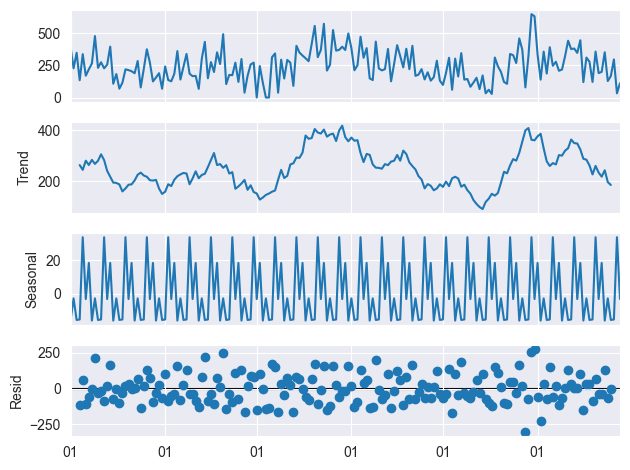

In [89]:
print('Daily Coffee Sales (Sum) Decomposition')
daily_data = temp.resample('D').sum()
result = seasonal_decompose(daily_data.dropna(), model='additive')
result.plot()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))
plt.show()

In [90]:
import pmdarima as pmd
# Auto-ARIMA Model
def arima_forecast(train, test, seasonal=True, m=7):
    # Fit the auto ARIMA model using the training data
    model = pmd.auto_arima(
        train['money'],
        seasonal=seasonal, 
        m=m,  # Weekly seasonality for daily data
        start_p=1, start_q=1, 
        max_p=3, max_q=3,
        d=None,  # Let the model determine if differencing is required
        D=1,  # Assume seasonal differencing is required
        trace=False,  
        error_action='ignore',  
        suppress_warnings=True, 
        stepwise=True
    )
    # Forecast for the test period
    test['ARIMA_forecast'] = model.predict(n_periods=len(test))
    return test['ARIMA_forecast']

Error Metrics for Each Model:
moving_average_forecast: MAE = 130.2528, MSE = 26995.5243
SES_forecast: MAE = 137.4768, MSE = 30069.2290
Holt_forecast: MAE = 151.0891, MSE = 35538.0996
Holt_Winters_forecast: MAE = 151.8549, MSE = 36842.4390
ARIMA_forecast: MAE = 155.9494, MSE = 38472.0324


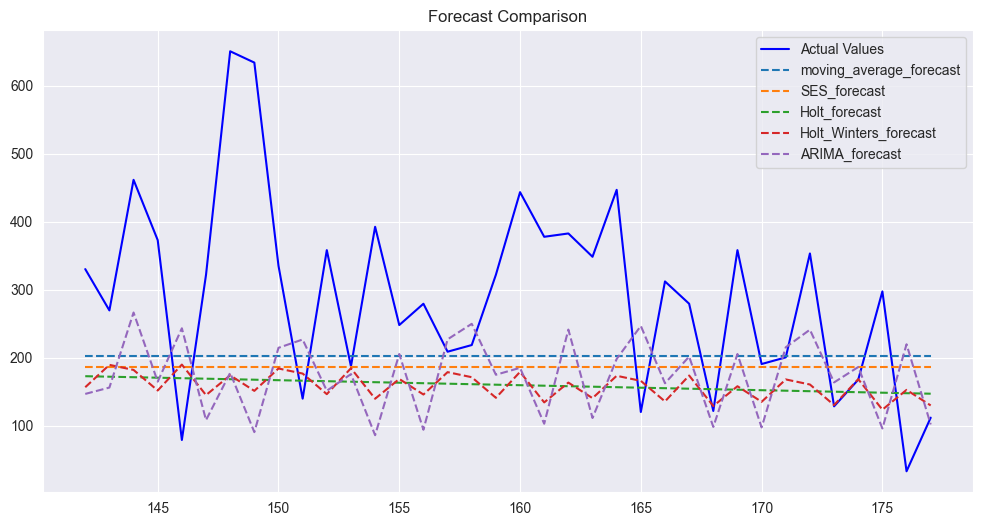

In [91]:
# Apply each model and compute the forecasts for the test set
test['moving_average_forecast'] = moving_average_forecast(train, test)
test['SES_forecast'] = ses_forecast(train, test)
test['Holt_forecast'] = holt_forecast(train, test)
test['Holt_Winters_forecast'] = holt_winters_forecast(train, test)
test['ARIMA_forecast'] = arima_forecast(train, test)

# Model Evaluation
metrics = {}

for col in test.columns[2:]:  # Exclude 'money' (the actual values)
    mae = mean_absolute_error(test['money'], test[col])
    mse = mean_squared_error(test['money'], test[col])
    metrics[col] = {'MAE': mae, 'MSE': mse}

# Print the evaluation results
print("Error Metrics for Each Model:")
for model_name, model_metrics in metrics.items():
    print(f"{model_name}: MAE = {model_metrics['MAE']:.4f}, MSE = {model_metrics['MSE']:.4f}")


# Visualize the actual values and forecasts
plt.figure(figsize=(12, 6))
plt.plot(test['money'], label='Actual Values', color='blue')
for col in test.columns[2:]:
    plt.plot(test[col], label=col, linestyle='--')
plt.legend()
plt.title('Forecast Comparison')
plt.show()


# Choosing the Best Model

In [92]:
import pandas as pd

def rank_models_by_error(metrics, criterion='MAE'):
    if criterion not in ['MAE', 'MSE']:
        raise ValueError("Criterion must be 'MAE' or 'MSE'.")

    df_metrics = pd.DataFrame(metrics).T  
    df_metrics.reset_index(inplace=True)  
    df_metrics.columns = ['Model', 'MAE', 'MSE'] 

    ranked_df = df_metrics.sort_values(by=criterion).reset_index(drop=True)
    ranked_df['Rank'] = ranked_df.index + 1

    return ranked_df

ranked_models_mae = rank_models_by_error(metrics, criterion='MAE')
print("Ranked Models by MAE:")
print(ranked_models_mae)

# Rank by MSE
ranked_models_mse = rank_models_by_error(metrics, criterion='MSE')
print("\nRanked Models by MSE:")
print(ranked_models_mse)


Ranked Models by MAE:
                     Model         MAE           MSE  Rank
0  moving_average_forecast  130.252778  26995.524344     1
1             SES_forecast  137.476817  30069.229014     2
2            Holt_forecast  151.089106  35538.099592     3
3    Holt_Winters_forecast  151.854940  36842.439024     4
4           ARIMA_forecast  155.949424  38472.032379     5

Ranked Models by MSE:
                     Model         MAE           MSE  Rank
0  moving_average_forecast  130.252778  26995.524344     1
1             SES_forecast  137.476817  30069.229014     2
2            Holt_forecast  151.089106  35538.099592     3
3    Holt_Winters_forecast  151.854940  36842.439024     4
4           ARIMA_forecast  155.949424  38472.032379     5


- Using MAE implies equal error treatment while MSE penalises larger errors. 
- In both cases we see the moving average model having the best results

# Hyperparameter Tuning

In [105]:
def simple_moving_average_tuning(train, test, window_sizes):
    results = {}

    # Evaluate each window size
    for window in window_sizes:
        sma = train.rolling(window=window).mean().shift(1) 
       
        predictions = sma[-len(test):].dropna()  
        actuals = test[:len(predictions)]  

        if not predictions.empty and not actuals.empty:
            mae = mean_absolute_error(actuals, predictions)
            mse = mean_squared_error(actuals, predictions)
            results[window] = {'MAE': mae, 'MSE': mse}

    return results

window_sizes = range(2, 31)  
results = simple_moving_average_tuning(train['money'], test['money'], window_sizes)

In [104]:
# Rank by MSE
ranked_models_mse = rank_models_by_error(results, criterion='MSE')
print("\nRanked Models by MSE:")
print(ranked_models_mse)


Ranked Models by MSE:
    Model         MAE           MSE  Rank
0      30  104.036111  17799.616176     1
1      29  103.930211  17956.039647     2
2      28  104.647480  18356.456300     3
3      27  105.018066  18506.772196     4
4      26  105.536880  18747.407666     5
5      25  108.091622  19109.649069     6
6      24  108.795694  19451.094605     7
7      23  109.431377  19997.937520     8
8      22  109.948283  20126.969777     9
9      21  111.568995  20255.744063    10
10     20  112.887083  20789.126087    11
11     19  113.277632  21330.477979    12
12     18  115.581975  22162.273680    13
13     16  116.541562  22184.827122    14
14     17  115.748725  22221.644878    15
15     15  116.572630  22567.248006    16
16     14  118.226548  23173.474097    17
17     12  121.931296  23372.742857    18
18     13  120.253547  23435.532397    19
19     11  122.859091  23635.380783    20
20     10  124.282389  24105.498658    21
21      9  125.720000  24125.624900    22
22      8  

In [113]:
ranked_models_mse = rank_models_by_error(results, criterion='MSE')
print("\nRanked Models by MSE:")
print(ranked_models_mse)


Ranked Models by MSE:
    Model         MAE           MSE  Rank
0      30  104.036111  17799.616176     1
1      29  103.930211  17956.039647     2
2      28  104.647480  18356.456300     3
3      27  105.018066  18506.772196     4
4      26  105.536880  18747.407666     5
5      25  108.091622  19109.649069     6
6      24  108.795694  19451.094605     7
7      23  109.431377  19997.937520     8
8      22  109.948283  20126.969777     9
9      21  111.568995  20255.744063    10
10     20  112.887083  20789.126087    11
11     19  113.277632  21330.477979    12
12     18  115.581975  22162.273680    13
13     16  116.541562  22184.827122    14
14     17  115.748725  22221.644878    15
15     15  116.572630  22567.248006    16
16     14  118.226548  23173.474097    17
17     12  121.931296  23372.742857    18
18     13  120.253547  23435.532397    19
19     11  122.859091  23635.380783    20
20     10  124.282389  24105.498658    21
21      9  125.720000  24125.624900    22
22      8  

Window difference is small but MAE might be a better decision criterion for robustness to outliers, clear interpretability and operation decisions like inventory management.

Hence, we can use a moving average model with window n = 30 to forecast.

# Forecasting
- Model is sutuable for only short term forecasting, setting as 10 days

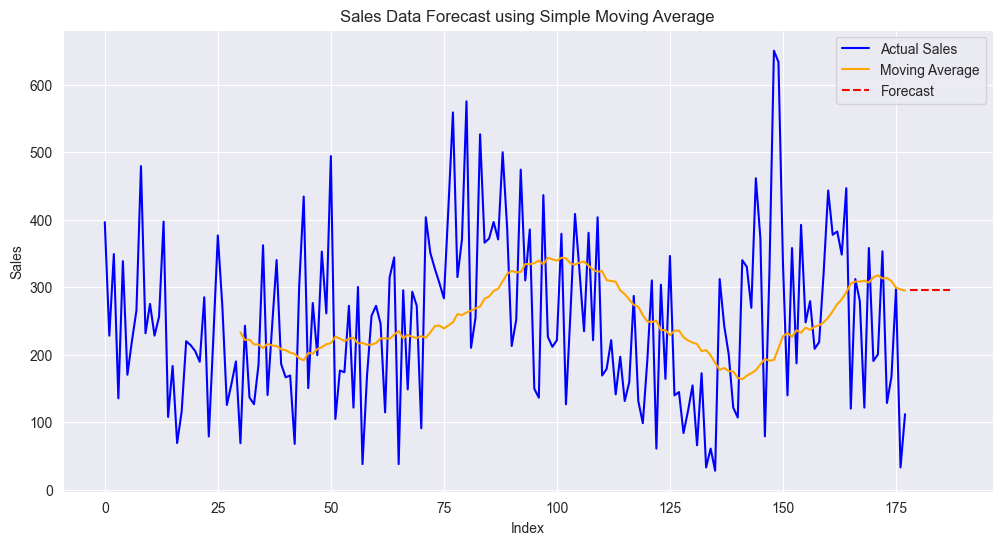

In [119]:
def simple_moving_average_forecast(data, window_size, forecast_periods):
    moving_average = data.rolling(window=window_size).mean().shift(1)  # Shift to avoid lookahead bias
    last_moving_average = moving_average.iloc[-1]  
    forecast = [last_moving_average] * forecast_periods  
    return forecast, moving_average

window_size = 30 
forecast_periods = 10  

forecast, moving_average = simple_moving_average_forecast(df_daily['money'], window_size, forecast_periods)
forecast_index = range(len(df_daily['money']), len(df_daily['money']) + forecast_periods)  
forecast_series = pd.Series(forecast, index=forecast_index)

plt.figure(figsize=(12, 6))
plt.plot(df_daily['money'], label='Actual Sales', color='blue')
plt.plot(moving_average, label='Moving Average', color='orange')
plt.plot(forecast_series, label='Forecast', color='red', linestyle='--')
plt.title('Sales Data Forecast using Simple Moving Average')
plt.xlabel('Index')
plt.ylabel('Sales')
plt.legend()
plt.show()
